## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Download Isic dataset here for fafster loading
# https://drive.google.com/file/d/1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG/view?usp=sharing
%cd /content
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG" -O rbv.zip && rm -rf /tmp/cookies.txt
!unzip -q rbv.zip -d ./

In [ ]:
#Settings
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from importlib import reload
import sys
import os
sys.path.append('/content/drive/My Drive/code/src')

import tensorflow as tf
import numpy as np
import callbacks

In [ ]:
%%capture
import models_r
import rbv_gen
import callbacks
import isic_gen

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
%%capture
reload(models_r);
reload(rbv_gen);
reload(callbacks);
reload(isic_gen);

## Train

In [ ]:
wt = tf.constant([0.2,0.7], dtype = tf.dtypes.float32)
norm = ''
def weighted_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.dtypes.int32)
    weights = tf.gather(wt, y_true)
    if norm == 'sig':
        err = tf.nn.sparse_softmax_cross_entropy_with_logits(y_true, y_pred)
    elif norm == 'softmax':
        err = tf.nn.sparse_sigmoid_cross_entropy_with_logits(y_true, y_pred)
    else:
        err = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    err = err*weights
    return err

In [ ]:
#model1
inputs = tf.zeros((1,128,128,3))
model1 = models_r.R2UNET(ch_init = 16, sig = True)
out = model1(inputs, False)

#model
# inputs = tf.zeros((1,128,128,3))
# model = models_r.R2UNET(ch_init = 16, sig = True)
# out = model(inputs, False)

# batch_stats = callbacks.CustomCallback();

# mean_ = isic_gen.find_mean(isic_gen.abs_train_img)
# std_dev_ = isic_gen.find_std_dev(isic_gen.abs_train_img, mean_)

####tf exclusive
train_gen, val_gen = rbv_gen.tf_dataset('./rbv/patches/patch_img', './rbv/patches/patch_gt', batch_trn = 30, batch_val=20, cache = 'cache0', img_wise_norm = True)
# val_gen = isic_gen.tf_dataset(batch_size = 30, center = False, cache = 'cache1')

####general
# train_gen = isic_gen.data_gen(batch_size = 20, norm = True)
# val_gen = isic_gen.data_gen(isic_gen.abs_val_img, isic_gen.abs_val_mask, 10, norm = True, mean_ = mean_ , std_dev_ = std_dev_)


model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),          
              loss= weighted_error,
              metrics=['accuracy', callbacks.F1, callbacks.SE, callbacks.SP, callbacks.JS, callbacks.DC])

In [ ]:
# model.save('/content/drive/My Drive/code/retina_final_img_wise_norm')
history1 = model1.fit(train_gen, steps_per_epoch = 200, epochs = 100, validation_data = val_gen, validation_steps = 50)
model1.save('content/drive/My Drive/code/rbv_r2unet_final_with_img_wise_norm_2')
# history = model.fit(train_gen, steps_per_epoch = 200, epochs = 50)

200/200 [==============================] - 52s 261ms/step - loss: 0.1194 - accuracy: 0.8457 - F1: 0.4687 - SE: 0.4802 - SP: 0.9615 - JS: 0.3757 - DC: 0.4690 - val_loss: 0.1253 - val_accuracy: 0.8256 - val_F1: 0.3418 - val_SE: 0.3834 - val_SP: 0.9478 - val_JS: 0.2697 - val_DC: 0.3421
Epoch 3/100
200/200 [==============================] - 53s 264ms/step - loss: 0.1174 - accuracy: 0.8521 - F1: 0.4860 - SE: 0.4953 - SP: 0.9661 - JS: 0.3949 - DC: 0.4863 - val_loss: 0.1370 - val_accuracy: 0.8370 - val_F1: 0.1871 - val_SE: 0.1534 - val_SP: 0.9905 - val_JS: 0.1715 - val_DC: 0.1875
Epoch 4/100
200/200 [==============================] - 53s 263ms/step - loss: 0.1167 - accuracy: 0.8538 - F1: 0.4969 - SE: 0.5045 - SP: 0.9678 - JS: 0.4061 - DC: 0.4971 - val_loss: 0.1311 - val_accuracy: 0.8453 - val_F1: 0.2783 - val_SE: 0.2251 - val_SP: 0.9902 - val_JS: 0.2371 - val_DC: 0.2788
Epoch 5/100
200/200 [==============================] - 53s 263ms/step - loss: 0.1157 - accuracy: 0.8572 - F1: 0.5022 - SE: 0

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, -1)
    # pred_mask = pred_mask[..., tf.newaxis]
    # print(pred_mask.shape)
    return pred_mask

In [ ]:
val_it = iter(val_gen)

In [ ]:
k = next(val_it)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


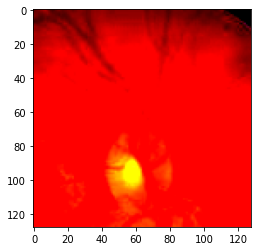

In [ ]:
plt.imshow(k[0][0])

In [ ]:
out = model1.predict(k[0])

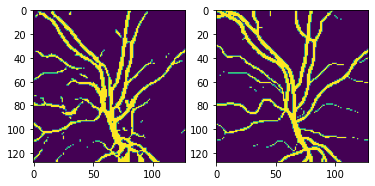

In [ ]:
plt.subplot(121)
plt.imshow(create_mask(out[0]))
plt.subplot(122)
plt.imshow(k[1][0])

In [ ]:
from PIL import Image
test_img = []
gt_img = []
test_mask = []
test_files = [os.path.abspath(os.path.join('/content/rbv/test', i)) for i in os.listdir('/content/rbv/test')]
for i in test_files:
    test = np.asarray(Image.open(i), dtype = "float32") / 255.
    patches = tf.image.extract_patches(test[tf.newaxis, ...], [1,128,128,1], strides = [1,128,128,1], rates = [1,1,1,1], padding = 'VALID')
    inputs = tf.map_fn(tf.image.per_image_standardization, tf.reshape(patches, (4, 128, 128, 3)))
    outputs = create_mask(model1.predict(inputs))
    mask = tf.concat([ tf.concat([outputs[0], outputs[1]], axis = 1) , tf.concat([outputs[2], outputs[3]], axis = 1)], axis = 0 )
    test_img.append(test)
    test_mask.append(mask)

In [ ]:
from PIL import Image
test_path = '/content/rbv/img256' 
mask_path = '/content/rbv/gt256/'
test_img = []
test_gt = []
test_mask = []
test_files = sorted([os.path.abspath(os.path.join(test_path, i)) for i in os.listdir(test_path)])
mask_files = sorted([os.path.abspath(os.path.join(mask_path, i)) for i in os.listdir(mask_path)])
for i in range(len(test_files)):
    test = np.asarray(Image.open(test_files[i]), dtype = "float32") / 255.
    patches = tf.image.extract_patches(test[tf.newaxis, ...], [1,128,128,1], strides = [1,128,128,1], rates = [1,1,1,1], padding = 'VALID')
    inputs = tf.map_fn(tf.image.per_image_standardization, tf.reshape(patches, (4, 128, 128, 3)))
    outputs = create_mask(model1.predict(inputs))
    mask = tf.concat([ tf.concat([outputs[0], outputs[1]], axis = 1) , tf.concat([outputs[2], outputs[3]], axis = 1)], axis = 0 )
    test_img.append(test)
    test_mask.append(mask)
    gt = np.asarray(Image.open(mask_files[i]), dtype = "float32") / 255.
    test_gt.append(gt)
print(len(test_files))


68


In [ ]:
i = 0
%cd /content/drive/My\ Drive/data/
!mkdir rbv_test_res
%cd rbv_test_res
!mkdir val2
%cd val2

for i in range(len(test_img)):
    tf.keras.preprocessing.image.array_to_img(test_img[i]).save('img%d.jpg'%i)
    tf.keras.preprocessing.image.array_to_img(test_mask[i][..., tf.newaxis]).save('mask%d.jpg'%i)
    tf.keras.preprocessing.image.array_to_img(test_gt[i][..., tf.newaxis]).save('gt%d.jpg'%i)
    # plt.subplot(121)
    # plt.imshow(test_img[i])
    # plt.subplot(122)
    # plt.imshow(test_mask[i], cmap = 'gray')
# test_ma
%cd /content/

/content/drive/My Drive/data
mkdir: cannot create directory ‘rbv_test_res’: File exists
/content/drive/My Drive/data/rbv_test_res
mkdir: cannot create directory ‘val2’: File exists
/content/drive/My Drive/data/rbv_test_res/val2
/content


mkdir: cannot create directory ‘/content/drive/My Drive/data/rbv_graph’: File exists


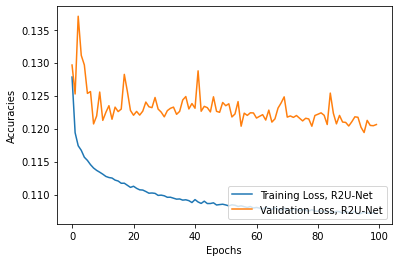

In [ ]:
# unet_acc = history1.history['acc']
# unet_val_acc = history1.history['val_acc']
r2unet_acc = history1.history['loss']
r2unet_val_acc = history1.history['val_loss']
%mkdir /content/drive/My\ Drive/data/rbv_graph
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
# plt.ylim([0.7,1])
# plt.plot(unet_acc, label='Training Accuracy, U-Net' )
# plt.plot(unet_val_acc, label='Validation Accuracy, U-Net')
plt.plot(r2unet_acc, label='Training Loss, R2U-Net' )
plt.plot(r2unet_val_acc, label='Validation Loss, R2U-Net')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('/content/drive/My Drive/data/rbv_graph/graph_loss.png')

In [ ]:
import matplotlib.pyplot as plt

train_it = iter(train_gen) 
k = next(train_it)
out1 = model1.predict(k[0])

def create_mask(pred_mask):
    pred_mask = tf.cast(tf.argmax(pred_mask, -1), tf.dtypes.float32)
    return pred_mask

for i in range(5):
    plt.figure()
    plt.imshow(k[0][i])
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/rbv_graph/orig_{i}.png')
    plt.figure()
    plt.imshow(k[1][i], cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/rbv_graph/ground_{i}.png')
    plt.figure()
    ok1 = create_mask(out1[i])
    plt.imshow(ok1, cmap = 'gray')
    plt.axis('off')
    plt.savefig(f'/content/drive/My Drive/data/rbv_graph/unet{i}.png')
    # plt.figure()
    # ok2 = create_mask(out2[i])
    # plt.imshow(ok2, cmap = 'gray')
    # plt.axis('off')
    # plt.savefig(f'/content/drive/My Drive/data/isicplots/r2unet{i}.png')

In [ ]:
res = {}
for i in history1.history.keys():
    res[i] = min(history1.history[i])

In [ ]:
res

{'DC': 0.3937237560749054,
 'F1': 0.3934606611728668,
 'JS': 0.30740272998809814,
 'SE': 0.39523014426231384,
 'SP': 0.9543691873550415,
 'accuracy': 0.8311810493469238,
 'loss': 0.1070818081498146,
 'val_DC': 0.18751908838748932,
 'val_F1': 0.18705597519874573,
 'val_JS': 0.17147985100746155,
 'val_SE': 0.15339072048664093,
 'val_SP': 0.947806179523468,
 'val_accuracy': 0.8255569338798523,
 'val_loss': 0.11941395699977875}